# DeepLab Demo

This demo will demostrate the steps to run deeplab semantic segmentation model on sample input images.

In [2]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
#@title Helper methods

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 1024
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, model_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Load frozen graph.
    with open(model_path) as fd:
        graph_def = tf.GraphDef.FromString(fd.read())
        
    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
#     width, height = image.size
#     resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
#     target_size = (int(resize_ratio * width), int(resize_ratio * height))
#     print resize_ratio,target_size
# #     target_size = (610,1024)
#     resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
#     print 'resized_im',resized_image.size,resized_image.mode
# #     resized_image = image.convert('RGB')
    resized_image = image
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_road_label_colormap():
    return np.asarray([
        [255,0,255],
        [0,255,0],
    ])


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_road_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray(['background', 'strip'])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

orignal_im (608, 1024) RGB JPEG
(1, 'time:', 0.3000000000000682)
(2, 'time:', 0.12999999999999545)
(3, 'time:', 0.17999999999994998)
(4, 'time:', 0.2599999999999909)
(5, 'time:', 0.3300000000000409)
(6, 'time:', 0.37999999999999545)
(7, 'time:', 0.4600000000000364)
(8, 'time:', 0.5099999999999909)
(9, 'time:', 0.5699999999999363)
(10, 'time:', 0.6400000000001)


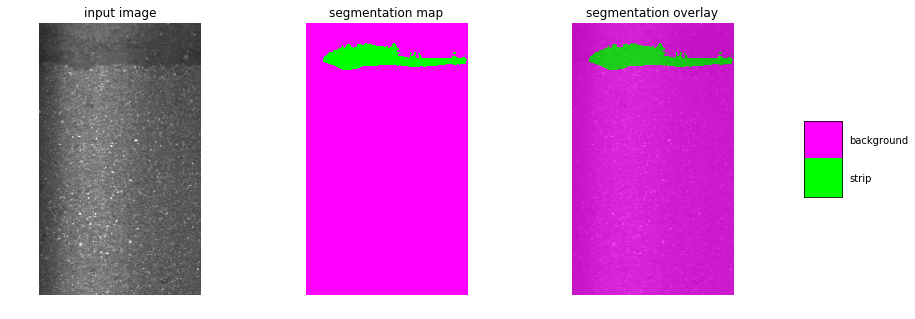

In [24]:
import time
if __name__ == '__main__':
    start = time.clock() 
    model_path = './datasets/pascal_voc_seg/exp/train_on_trainval_set_mobilenetv2/export/frozen_inference_graph.pb'
    image_path = './datasets/pascal_voc_seg/VOCdevkit/VOC2012/JPEGImages/G30IA-372+342120-372+431320-0.jpg'
#     image_path = './datasets/pascal_voc_seg/VOCdevkit/VOC2012-ORI/JPEGImages/G30IA-372+342120-372+431320.jpg'
    MODEL = DeepLabModel(model_path)
    orignal_im = Image.open(image_path)
    print 'orignal_im',orignal_im.size,orignal_im.mode,orignal_im.format
    start = time.clock() 
    orignal_im = Image.open(image_path)
    for j in range(1,11):
        start = time.clock() 
        for i in range(j):
            resized_im, seg_map = MODEL.run(orignal_im)
        end = time.clock()
        print(j,'time:', end - start)
    vis_segmentation(resized_im, seg_map)
    